This notebook consists of the code to train and test the Dense SE ResNet model with Parameter sharing.

We have built our code taking references from the following repository for the custom ResNet Model:https://github.com/AlirezaAzadbakht/kernel-sharing

In [1]:
#importing all the libraries
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn

import torchvision
import torchvision.transforms as transforms


import os
import argparse

from torchvision.datasets import CIFAR10, CIFAR100
import torchvision.transforms as transforms
import random



In [2]:
# defining the presence of a CPU or GPU
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'device: {device}')

device: cuda


In [3]:
import torchvision
from torchvision import datasets, transforms

# Defining our transformations for training and testing
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(32, scale=(0.95, 1.0), ratio=(0.9, 1.1), interpolation=2),
    transforms.RandomRotation(10),
    transforms.RandomCrop(32, padding=2),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(0.1, 0.1, 0.1, 0.1),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

# creating Datasets
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=train_transform)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=test_transform)

# Creating the DataLoaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=4)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=100, shuffle=False, num_workers=4)


100%|██████████| 170498071/170498071 [00:13<00:00, 12711511.00it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [4]:
#Model for reduced parameters
from torch import nn
from torch.nn.parameter import Parameter

BN_momentum = 0.1

# Squeeze and Excitation Algorithm used
class SE(nn.Module):
    def __init__(self,
                 channel,
                 reduction=16):
        super(SE, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(channel, channel // reduction, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(channel // reduction, channel, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.avg_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y.expand_as(x)

def conv3x3(in_planes, out_planes, stride=1):
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride, padding=1, bias=False)


def conv1x1(in_planes, out_planes, stride=1):

    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)


#Squeeze and Excitation Block
class SEBasicBlock(nn.Module):
    expansion = 1
    def __init__(self, inplanes, planes, stride=1, reduction=16, new_resnet=False, share_w=None):
        super(SEBasicBlock, self).__init__()
        self.new_resnet = new_resnet
        self.conv1 = conv3x3(inplanes, planes, stride)
        if share_w != None and inplanes == planes:
            self.conv1.weight = share_w
        self.bn1 = nn.BatchNorm2d(
            inplanes if new_resnet else planes, momentum=BN_momentum)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes, 1)
        if share_w != None:
            self.conv2.weight = share_w
        self.bn2 = nn.BatchNorm2d(planes, momentum=BN_momentum)
        self.se = SE(planes, reduction)
        if inplanes != planes:
            self.downsample = nn.Sequential(nn.Conv2d(inplanes, planes, kernel_size=1, stride=stride, bias=False),
                                            nn.BatchNorm2d(planes, momentum=BN_momentum))
        else:
            self.downsample = lambda x: x
        self.stride = stride
        self.output = planes * self.expansion

    def _old_resnet(self, x):
        residual = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.se(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out
    def _new_resnet(self, x):
        residual = x

        out = self.bn1(x)
        out = self.relu(out)
        out = self.conv1(out)

        out = self.bn2(out)
        out = self.relu(out)
        out = self.conv2(out)

        out = self.se(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual

        return out

    def forward(self, x):
        if self.new_resnet:
            return self._new_resnet(x)
        else:
            return self._old_resnet(x)

#ResNet for Cifar10
class CifarNet(nn.Module):


    def __init__(self, block, n_size, num_classes=10, reduction=16, new_resnet=False, dropout=0., share_stages=[False, False, True], sync=True):
        super(CifarNet, self).__init__()
        self.inplane = 16
        self.new_resnet = new_resnet
        self.dropout_prob = dropout
        self.conv1 = nn.Conv2d(
            3, self.inplane, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(self.inplane, momentum=BN_momentum)
        self.relu = nn.ReLU(inplace=True)
        self.sync = sync
        self.layer1 = self._make_layer(
            block, 64, blocks=n_size, stride=1, reduction=reduction, share=share_stages[0])
        self.layer2 = self._make_layer(
            block, 128, blocks=n_size, stride=2, reduction=reduction, share=share_stages[1])
        self.layer3 = self._make_layer(
            block, 256, blocks=n_size, stride=2, reduction=reduction, share=share_stages[2])

        self.avgpool = nn.AdaptiveAvgPool2d(1)
        if self.dropout_prob > 0:
            self.dropout_layer = nn.Dropout(p=self.dropout_prob, inplace=True)
        self.fc = nn.Linear(self.inplane, num_classes)
        self.initialize()

    def initialize(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def _make_layer(self, block, planes, blocks, stride, reduction, share=True):
        strides = [stride] + [1] * (blocks - 1)
        layers = []
        conv = conv3x3(planes, planes, 1)
        conv_w = Parameter(conv.weight.clone().detach())

        for stride in strides:
            if self.sync and share:
                layers.append(block(self.inplane, planes, stride,
                                    reduction, new_resnet=self.new_resnet,
                                    share_w=conv_w))
            else:
                layers.append(block(self.inplane, planes, stride,
                                    reduction, new_resnet=self.new_resnet))
            self.inplane = layers[-1].output

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        if self.dropout_prob > 0:
            x = self.dropout_layer(x)
        x = self.fc(x)

        return x

#Our model with 6 residual blocks in each ;ayer
def se_resnet_d_6(**kwargs):
    model = CifarNet(SEBasicBlock, 6, **kwargs)
    return model




In [5]:
#defining the model
modelSE=se_resnet_d_6().to(device)




In [6]:
#Parameter Count
def count_trainable_parameters(model):
    return sum(param.numel() for param in model.parameters() if param.requires_grad)



print(f"The model has {count_trainable_parameters(modelSE)} trainable parameters.") # printing the output of the function




The model has 3116378 trainable parameters.


In [7]:
#defining the loss and optimizer function
from torch.optim.lr_scheduler import CosineAnnealingLR
import torch.optim as optim
criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(modelSE.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4, nesterov=True)
#optimizer = optim.Adam(modelSE.parameters(), lr=0.01, weight_decay=5e-4)


scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[60, 85,100], gamma=0.1)


In [8]:
#Training and evaluation
epochs=110
steps=0
grad_clip=0.1
test_accplt=[]

train_losses=[]
test_losses=[]
for e in range(epochs):
    train_loss=0.0
    test_loss=0.0
    modelSE.train()
    for images,labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        log_ps=modelSE(images)
        loss=criterion(log_ps,labels)
        loss.backward()
        if grad_clip:
          nn.utils.clip_grad_value_(modelSE.parameters(), grad_clip)
        optimizer.step()
        train_loss+=loss.item()*images.size(0)

    modelSE.eval()
    test_acc=[]
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        output = modelSE(images)
        loss = criterion(output, labels)
        predictions = torch.argmax(output, dim=1)
        test_loss += loss.item() * images.size(0)
        k=torch.sum(predictions == labels)

        val = 100*(k/len(images))

        test_acc.append(val)


    scheduler.step()



    train_loss=train_loss/len(train_loader.sampler)
    train_losses.append(train_loss)

    test_loss=test_loss/len(test_loader.sampler)
    test_losses.append(test_loss)

    test_accuracy=(sum(test_acc)/len(test_acc)).item()
    test_accplt.append(test_accuracy)

    print('Epoch:{}\tTraining Loss : {:.6f}\t test Loss :{:.6f}'.format(
          e+1,
          train_loss,
          test_loss


      ))
    print('accuracy :',(sum(test_acc)/len(test_acc)).item())

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch:1	Training Loss : 1.514529	 test Loss :1.218010
accuracy : 55.03999710083008
Epoch:2	Training Loss : 1.089149	 test Loss :1.018752
accuracy : 64.27999877929688
Epoch:3	Training Loss : 0.880801	 test Loss :0.949109
accuracy : 67.08000183105469
Epoch:4	Training Loss : 0.758235	 test Loss :0.744055
accuracy : 74.90999603271484
Epoch:5	Training Loss : 0.679695	 test Loss :0.631662
accuracy : 78.1500015258789
Epoch:6	Training Loss : 0.623517	 test Loss :0.622468
accuracy : 79.47999572753906
Epoch:7	Training Loss : 0.578449	 test Loss :0.619030
accuracy : 79.22000122070312
Epoch:8	Training Loss : 0.542445	 test Loss :0.527313
accuracy : 81.86000061035156
Epoch:9	Training Loss : 0.507396	 test Loss :0.593803
accuracy : 80.88999938964844
Epoch:10	Training Loss : 0.477749	 test Loss :0.605047
accuracy : 80.75
Epoch:11	Training Loss : 0.456107	 test Loss :0.484299
accuracy : 83.20999908447266
Epoch:12	Training Loss : 0.434805	 test Loss :0.461964
accuracy : 84.44999694824219
Epoch:13	Train

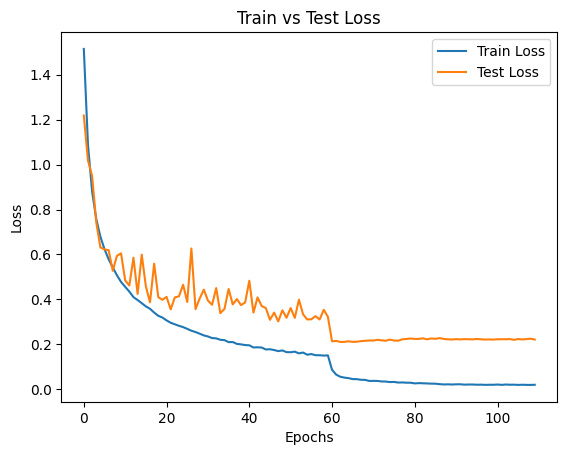

In [9]:
# plotting the train test curve
import matplotlib.pyplot as plt
plt.plot(train_losses,label='Train Loss')
plt.plot(test_losses,label='Test Loss')

plt.legend()

# Labeling the axes
plt.xlabel('Epochs')  # Label for the x-axis
plt.ylabel('Loss')    # Label for the y-axis

# You can also add a title to the plot if needed
plt.title('Train vs Test Loss')

# Display the plot
plt.show()

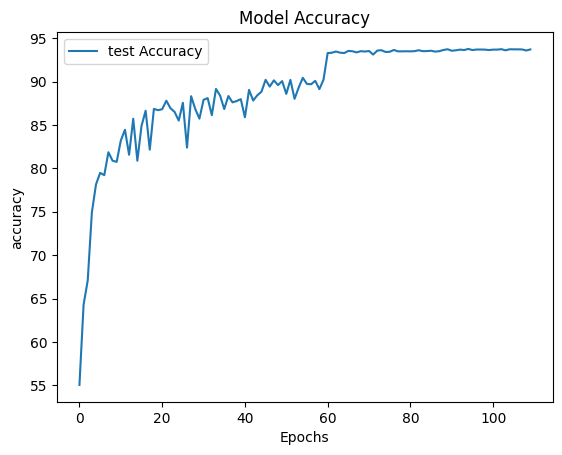

In [10]:
#plotting the accuracy over 110 epochs
plt.plot(test_accplt,label='test Accuracy')

plt.legend()

# Labeling the axes
plt.xlabel('Epochs')  # Label for the x-axis
plt.ylabel('accuracy')    # Label for the y-axis

# You can also add a title to the plot if needed
plt.title('Model Accuracy')

# Display the plot
plt.show()


In [11]:
#Accuracy of the model
acc_list=[]
for images,labels in test_loader:
    with torch.no_grad():
        images, labels = images.to(device), labels.to(device)
        outputs = modelSE(images)
        prediction = torch.argmax(outputs, dim=1)
        k=torch.sum(prediction == labels)

        val = 100*(k/len(images))

        acc_list.append(val)

print('accuracy :',(sum(acc_list)/len(acc_list)).item())

accuracy : 93.70999908447266
